## 2.  Redes recurrentes sobre texto
Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto proporcionadas por GMB (*Groningen Meaning Bank*) para reconocimiento de entidades y tagger. Trabajaremos con el dataset proprocionado a través de la interfaz de Kaggle en el siguiente __[link](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, con mas de un millón de palabras trabajaremos este dataset para realizar predicciones sobre distintas tareas, del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />
<hr>

Primero cargamos las librerias necesarias para el experimento.

In [1]:
%matplotlib inline
import time
import random
import sys
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional, CuDNNGRU,GRU
from keras.callbacks import LambdaCallback

plt.style.use('ggplot')

Using TensorFlow backend.


Los datos a utilizar corresponden al corpus anotado para el Reconocimiento de Entidades Nombradas (NER por sus siglas en inglés) usando el corpus GMB (Groningen Meaning Bank) para la clasificación de entidades. Este es el extracto del corpus GMB que está etiquetado, anotado y construido específicamente para entrenar al clasificador para predecir las entidades con nombre, como el nombre, la ubicación, etc.

Trabajaremos realizando la tarea de POS tagging (part-of-speech): es el proceso de asignar a cada palabra de un texto su categoría gramatical. Este proceso se puede realizar de acuerdo con la definición de la palabra o el contexto en que aparece, por ejemplo su relación con las palabras adyacentes en una frase, oración (como realiza el desambiguador léxico en ventana deslizante), o en un párrafo.

Uno de los usos de este etiquetado tiene lugar en el contexto de la lingüística computacional, mediante el empleo de algoritmos que realizan el etiquetado usando etiquetas descriptivas predefinidas.
<hr>

El dataset es descargado de [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). Se cargan los datos.

In [2]:
file = "./entity-annotated-corpus/ner.csv.zip"
df_ner = pd.read_csv(file, compression="infer", error_bad_lines=False, encoding="Latin-1")
df_ner.dropna(inplace=True) 

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
df_ner.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [3]:
df_ner.shape

(1050794, 25)

Los datos consisten en 25 características (columnas) con 1050794 entradas. De las columnas, solo dos consisten en números y el resto son caracteres.

In [4]:
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050794 entries, 0 to 1050794
Data columns (total 25 columns):
Unnamed: 0         1050794 non-null int64
lemma              1050794 non-null object
next-lemma         1050794 non-null object
next-next-lemma    1050794 non-null object
next-next-pos      1050794 non-null object
next-next-shape    1050794 non-null object
next-next-word     1050794 non-null object
next-pos           1050794 non-null object
next-shape         1050794 non-null object
next-word          1050794 non-null object
pos                1050794 non-null object
prev-iob           1050794 non-null object
prev-lemma         1050794 non-null object
prev-pos           1050794 non-null object
prev-prev-iob      1050794 non-null object
prev-prev-lemma    1050794 non-null object
prev-prev-pos      1050794 non-null object
prev-prev-shape    1050794 non-null object
prev-prev-word     1050794 non-null object
prev-shape         1050794 non-null object
prev-word          1050794 n

> a) En esta primera instancia trabajaremos con la tarea de realizar un POS *tag* (*Part of Speech*) sobre cada una de las palabras en las sentencias que se nos presenta en los datos, también puede intentar el NER (*Named Entity Recogntion*) sobre la columna *tag*, esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia sin *shift*, por lo que necesitaremos una estructura de red adecuada a esto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?

De las 25 columnas solo se seleccionan 4: "lemma", "pos", "tag" y "prev-iob".
- *lemma* es el resultado de aplicar lemmatization a la palabra correspondiente a la raiz de la palabra, eliminando inflexiones. Por ejemplo, la palabra *saw* tendría como lemma *see*, o *saw* dependiendo del contexto (verbo o sustantivo). A diferencia de stemming, donde simplemente se reduce la palabra por medio de truncado, lemmatization reduce la palabra en base a diccionario. En este caso el lemma se obtiene de la palabra en *lowercase*.
- *pos* es la etiqueta de Part-of-Speech que corresponde a la función de una palabra dentro de una oración.
- *tag* es el mecanísmo de tags que usa NER llamadio IOB (In, Out, Begin).
- *prev-iob* tag de la palabra previa

Se decide trabajar con *lemmas* porque son versiones más cortas de las palabras y que captan el significado principal de ellas. Para este dataset el lemma se obtiene de las palabras procesadas, donde se eliminan las mayúsculas, así dos palabras donde varía la primera letra (comienzo de oración) serán tratadas como iguales. Además, la lemmatization permite trabajar con el significado de la palabra más que la forma en que pueda estar escrita. Así, diferentes conjugaciones de un verbo deberían caer dentro de un mismo lema (see = saw, seen, seeing, sees). Esto permite reducir la dimensionalidad del problema, que sería muy diferente al considerar todas las variaciones de un lemma dentro del dataset.

Debido a que seleccionamos solo 4 columas se reduce la dimensión de los datos a 1050794x4.

In [5]:
dataset = df_ner.loc[:,["lemma","pos","tag","prev-iob"]]

In [6]:
dataset.head()

,lemma,pos,tag,prev-iob
0,thousand,NNS,O,__START1__
1,of,IN,O,O
2,demonstr,NNS,O,O
3,have,VBP,O,O
4,march,VBN,O,O


> Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los pos tagger, esto es un arreglo de arreglos de lemmas y un arreglo de arreglos de tags respectivamente. ¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?

Se separa la variable dataset en el conjunto X (matriz de lemmas) y el conjunto Y (matriz de labels).

In [7]:
sentence = []
labels_sentence = []
dataX,dataY = [],[]
#uniques
lemmas,labels = set(), set()

for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])

In [8]:
print("Cantidad labels: ", len(labels))
print("Cantidad lemmas: ", len(lemmas))
print("Tamaño matriz de lemmas: ", dataX.shape)
print("Tamaño matriz de labels: ", dataY.shape)

Cantidad labels:  41
Cantidad lemmas:  20243
Tamaño matriz de lemmas:  (48081,)
Tamaño matriz de labels:  (48081,)


La cantidad de labels que hay es 41, hay 20.243 lemmas. La cantidad de filas de las matrices X e Y es de 48.081. Como se explica en el siguiente punto, las entradas en el dataset no tienen igual largo.

> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen
las palabras en todo el dataset. ¿Se observa una ley Zipf? ¿Cambia el resultado cuando se separan los textos de acuerdo a su clase/categorı́a? Comente.

Para estudiar de largos de los textos a procesar, se obtiene el largo de todas las sentencias y se hace un histograma y un boxplot de los largos calculados.

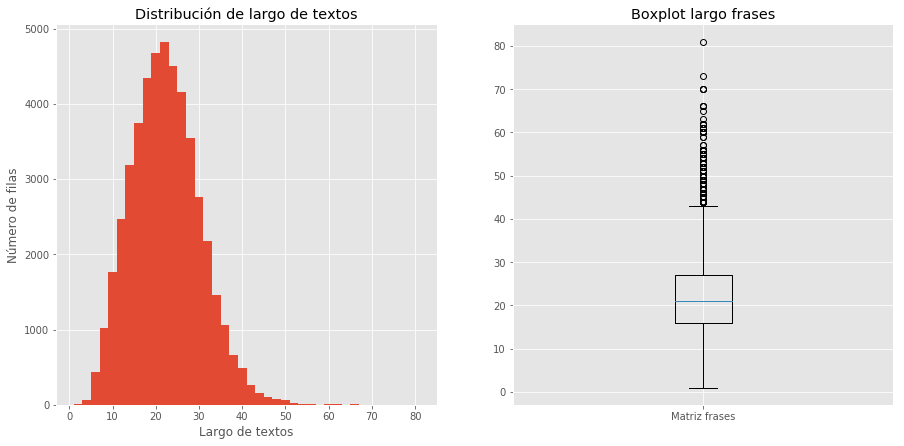

In [9]:
phrases_len = []
for row in dataX:
    phrases_len.append(len(row))

figsize(15,7)
plt.subplot(121)
plt.hist(phrases_len, bins=40)
plt.xlabel("Largo de textos")
plt.ylabel("Número de filas")
plt.title("Distribución de largo de textos")

plt.subplot(122)
plt.boxplot(phrases_len, labels=["Matriz frases"])
plt.title("Boxplot largo frases")
plt.show()

Los gráficos anteriores muestran que las sentencias si tienen un largo diferente y que hay una mayor concentración de largos entre 10 y 40, siendo el largo que más se repite el rango 20-30 (más cercano a 20). El boxplot indica que existen varios valores de largos outliers después del 40. En definitiva las sentencias del dataset no son de larga extensión.
<hr>
La llamada ley de Zipf, formulada en la década de 1940 por George Kingsley Zipf, es una ley según la cual en una determinada lengua la frecuencia de aparición de distintas palabras sigue una distribución que puede aproximarse por

\\[P_n \sim \frac{1}{n^a}\\]

donde $P_n$ representa la frecuencia de la n-ésima palabra más frecuente y el exponente a es un número real positivo, en general ligeramente superior a 1,1. Esto significa que el segundo elemento se repetirá aproximadamente con una frecuencia de 1/2 de la del primero, el tercer elemento con una frecuencia de 1/3 y así sucesivamente. La ley de Zipf se cumple para la mayoría de las lenguas.

Ref: https://es.wikipedia.org/wiki/Ley_de_Zipf

Para corroborar la Ley de Zipf se calcula la frecuencia de las palabras a través de todas las sentencias y se gráfica la frecuencia en función de las palabras. A su vez, y solo a modo de ilustración, se hace el mismo proceso con los labels.

In [10]:
def get_frequency(data):
    words = dict()
    for phrase in data:
        for word in phrase:
            if word not in words:
                words[word] = 0
            words[word] += 1
    words = sorted(words.items(), key=operator.itemgetter(1), reverse=True)
    return words

words_freq = get_frequency(dataX)
lemmas_freq = get_frequency(dataY)

w, w_freq = zip(*words_freq)
l, l_freq = zip(*lemmas_freq)

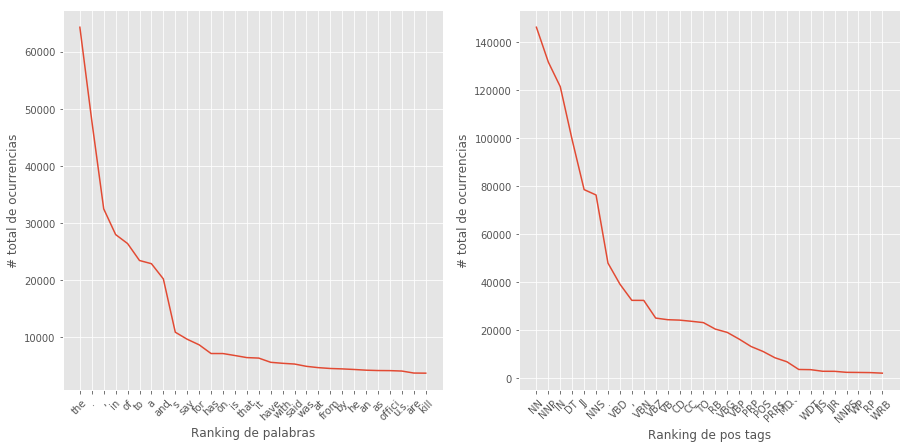

In [11]:
x_ = np.arange(30)
plt.subplot(121)
plt.plot(x_, w_freq[:30])
plt.xticks(x_, w[:30], rotation=45)
plt.xlabel("Ranking de palabras")
plt.ylabel("# total de ocurrencias")

plt.subplot(122)
plt.plot(x_, l_freq[:30])
plt.xticks(x_, l[:30], rotation=45)
plt.xlabel("Ranking de pos tags")
plt.ylabel("# total de ocurrencias")
plt.show()

Los gráficos anteriores se corresponden con la Ley de Zipf donde para las primeras palabras hay una gran cantidad de repeticiones (y además que son palabras que por lo general se tratan como *stopwords*) y que rápidamente decae al ir observando nuevas palabras. Como se mencionó anteriormente, las palabras que más se repiten en un dataset no preprocesado son las stopwords, palabras que por si no tienen un valor semántico.

La Ley de Zipf tiene un fenómeno observable al aplicar el logarítmo a la frecuencia de las palabras. Esto produce que en la parte central del gráfico se pueda interpretar como una función lineal, tal como se ve en el caso de la frecuencia de los lemmas. Para la frecuencia de los labels no se da este fenómeno pues no se está analizando la frecuencia de palabras, sino de los tags.

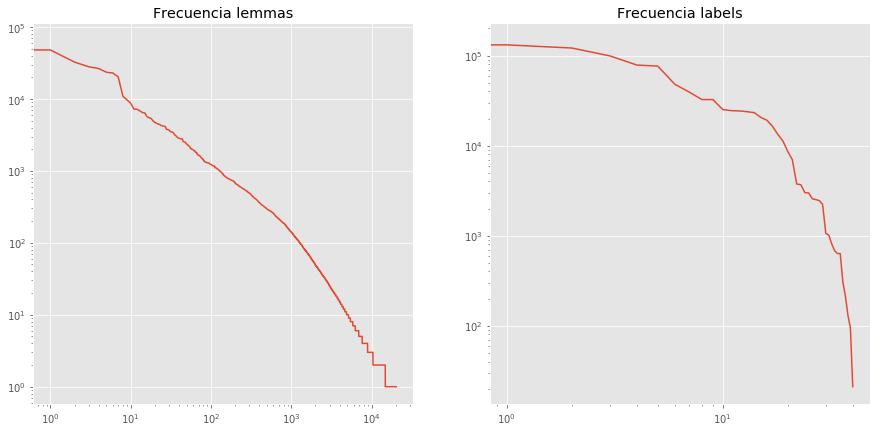

In [14]:
plt.subplot(121)
plt.loglog(np.arange(len(w)), w_freq)
plt.title("Frecuencia lemmas")
plt.subplot(122)
plt.loglog(np.arange(len(l)), l_freq)
plt.title("Frecuencia labels")
plt.show()

> c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas. Además de esto, debido al largo distinto de las sentencias se deberá realizar *padding* para estandarizar el largo, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" y codificado quedará como [32,4,*0, 0*].

Primero determinamos el tamaño de la sentencia más larga. Con esto podrá hacerse un padding para que todas las sentencias tengan la misma dimensión.

In [12]:
max_len = 0
for lemma in dataX:
    max_len = max(len(lemma), max_len)
print("Tamaño sentencia más larga: ", max_len)

Tamaño sentencia más larga:  81


El largo máximo es 81, por lo que hay que agregar un delimitador que indique cuando hay padding. Si se observan los histogramas de largo de sentencias se ve que la mayoría de las sentencias tienen un largo menor a 81. Es por esto que se introducirá una gran cantidad de información a la matriz de datos, pero esta 

A su vez, se agrega el lemma *ENDPAD* que indica espacios en blancos en una sentencia, para dejarlas todas del mismo largo, y su correspondiente label *ENDP*.

In [13]:
lemmas.add("ENDPAD")
labels.add("ENDPAD")

Antes de hacer el cambio de palabras a índices, la primera sentencia es de la siguiente forma.

In [14]:
print(dataX[0])

['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.']


Así, se hace la conversión de lemmas y labels a números. dataX y dataY se cambian para contener sentencias con los índices de cada palabra.

In [15]:
lemma2idx = {w: i for i, w in enumerate(lemmas)} # Convertir texto a numeros
lab2idx = {t: i for i, t in enumerate(labels)} # Convertir labels a numeros
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[pos] for pos in pos_tags ] for pos_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

Con el cambio, la primera sentencia queda como se muestra a continuación.

In [16]:
print(dataX[0])

[10293, 7776, 16500, 13036, 13031, 12686, 16502, 1100, 5509, 14759, 9731, 15135, 9381, 1117, 3241, 14759, 826, 7776, 3752, 17146, 14005, 19085, 19325, 9856]


In [17]:
X = sequence.pad_sequences(dataX, maxlen=max_len, padding="post", value=lemma2idx["ENDPAD"])
y = sequence.pad_sequences(dataY, maxlen=max_len, padding="post", value=lab2idx["ENDPAD"])

In [18]:
print(X[0])

[10293  7776 16500 13036 13031 12686 16502  1100  5509 14759  9731 15135
  9381  1117  3241 14759   826  7776  3752 17146 14005 19085 19325  9856
 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054
 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054
 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054
 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054 10054
 10054 10054 10054 10054 10054 10054 10054 10054 10054]


In [19]:
print(y[0])

[26  6 26  9 39  6 28 41 25 27 14  6 28 23 25 27 14  6 24 26  6 27 14 12
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36 36]


In [20]:
print(lemma2idx['ENDPAD'])
print(lab2idx['ENDPAD'])

10054
36


In [21]:
X.shape

(48081, 81)

> d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece mas conveniente al rellenar con el valor especial ¿Al principio o al final de la sentencia? Comente

En el punto anterior se aplicó padding al final de las sentencias. Se prefiere dejar al final de la oración pues es fácil identificar la hubicación de la información, si esta está siempre al comienzo del arreglo, y a su vez es fácil identificar cuando esta termina con solo llegar a la etiqueta *ENDPAD*.

Dependiendo del dominio del problema puede ser más conveniente colocar en un lugar el padding en vez del otro.

> e) Para el poder entregar una clasificación sobre los distintos *pos tagger* es necesario tranformarlas a *one hot vectors*, debido a que están codificadas en números enteros, con esto se quedará con un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *pos tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación ¿Cuáles son las dimensiones de entrada y salida de cada conjunto? Comente

In [22]:
print("Dimensión X sentencias: ", X.shape)
print("Dimensión y post tags : ", y.shape)

Dimensión X sentencias:  (48081, 81)
Dimensión y post tags :  (48081, 81)


In [23]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

In [24]:
y.shape

(48081, 81, 42)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [26]:
print("Tamaño X_train: ", X_train.shape)
print("Tamaño y_train: ", y_train.shape)
print("Tamaño X_test : ", X_test.shape)
print("Tamaño y_test : ", y_test.shape)

Tamaño X_train:  (33656, 81)
Tamaño y_train:  (33656, 81, 42)
Tamaño X_test :  (14425, 81)
Tamaño y_test :  (14425, 81, 42)


> f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* el texto, entrenela y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *pos tag* a cada uno de estos *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red.

# agregar calculo de dimensión

In [40]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_len))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
results = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 42)            4242      
Total params: 705,250
Trainable params: 705,250
Non-trainable params: 0
_________________________________________________________________


/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 52s 2ms/step - loss: 1.0717 - acc: 0.7491 - val_loss: 0.7590 - val_acc: 0.7935
Epoch 2/3
33656/33656 [==============================] - 50s 1ms/step - loss: 0.6029 - acc: 0.8372 - val_loss: 0.4029 - val_acc: 0.8881
Epoch 3/3
33656/33656 [==============================] - 51s 2ms/step - loss: 0.2690 - acc: 0.9294 - val_loss: 0.1811 - val_acc: 0.9526


In [41]:
print("Loss: %.4f\tAccuracy: %.4f" % (scores[0], scores[1]))

Loss: 0.1811	Accuracy: 0.9526


Se tiene un buen desempeño de la red con un 95.3% de accuracy.

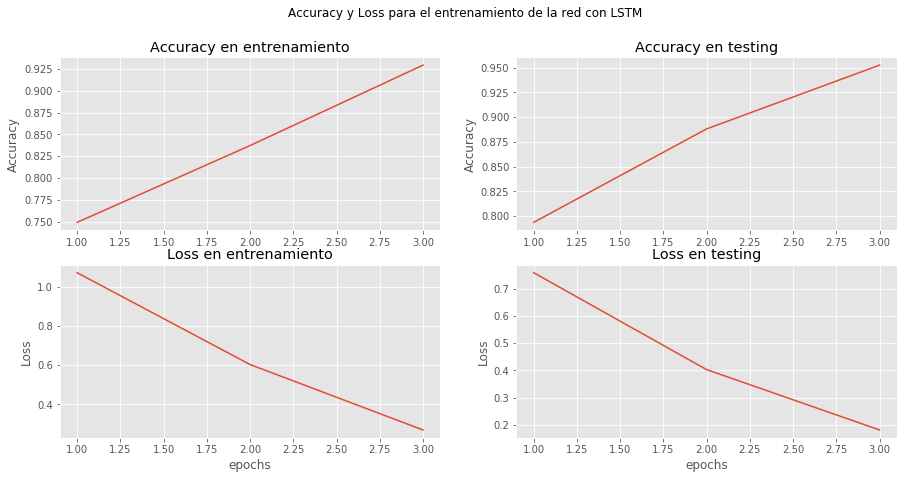

In [65]:
plt.suptitle("Accuracy y Loss para el entrenamiento de la red con LSTM")
plt.subplot(221)
plt.plot(range(1,4), results.history['acc'])
plt.ylabel('Accuracy')
plt.title('Accuracy en entrenamiento')
plt.subplot(222)
plt.plot(range(1,4), results.history['val_acc'])
plt.ylabel('Accuracy')
plt.title('Accuracy en testing')
plt.subplot(223)
plt.plot(range(1,4), results.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss en entrenamiento')
plt.subplot(224)
plt.plot(range(1,4), results.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss en testing')
plt.show()

> g) Varı́e la dimensionalidad del embedding inicial y determine si aumenta o disminuye el error de clasificación. Comente.

In [25]:
score_models = {}
times = {}
embedding_vectors = [16, 32, 42, 64, 81, 128, 256]
for size in embedding_vectors:
    print("---- Dimensión Embedding %d ----" % size)
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=size, input_length=max_len))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    duration = time.time()-start_time
    print("Tiempo embeding {} : {}".format(size, duration))
    score_models[size] = model.evaluate(X_test, y_test, verbose=0)
    times[size] = duration

---- Dimensión Embedding 16 ----
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 16)            323904    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 42)            4242      
Total params: 374,946
Trainable params: 374,946
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 45s 1ms/step - loss: 1.1094 - acc: 0.7407 - val_loss: 0.7905 - val_acc: 0.7764
Epoch 2/3
33656/33656 [==============================] - 43s 1ms/step - loss: 0.7123 - acc: 0.8079 - val_loss: 0.5857 - val_acc: 0.8478
Epoch 3/3
33656/33656 [======================

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 65s 2ms/step - loss: 0.8576 - acc: 0.8012 - val_loss: 0.3643 - val_acc: 0.9100
Epoch 2/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.1795 - acc: 0.9553 - val_loss: 0.1090 - val_acc: 0.9686
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.0862 - acc: 0.9738 - val_loss: 0.0834 - val_acc: 0.9737
Tiempo embeding 256 : 198.1886179447174


In [30]:
# imprimir errores y tiempo
for size in embedding_vectors:
    print("E.V: %d,\t Acc: %.3f\tLoss: %.3f\tTime:%.1f" %
          (size, score_models[size][1], score_models[size][0], times[size]))

E.V: 16,	 Acc: 0.905	Loss: 0.336	Time:130.6
E.V: 32,	 Acc: 0.954	Loss: 0.184	Time:126.3
E.V: 42,	 Acc: 0.961	Loss: 0.152	Time:135.7
E.V: 64,	 Acc: 0.966	Loss: 0.122	Time:139.9
E.V: 81,	 Acc: 0.968	Loss: 0.111	Time:150.1
E.V: 128,	 Acc: 0.971	Loss: 0.099	Time:161.0
E.V: 256,	 Acc: 0.974	Loss: 0.083	Time:198.2


> h) Use Dropout para entrenar la LSTM. ¿El Dropout mejora el desempeño de la red? Señale cuales podrı́an ser las causas del comportamiento observado.

In [29]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_len))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
start_time = time.time()
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
duration = time.time() - start_time
score = model.evaluate(X_test, y_test, verbose=0)

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 53s 2ms/step - loss: 1.0850 - acc: 0.7464 - val_loss: 0.7700 - val_acc: 0.7864
Epoch 2/3
33656/33656 [==============================] - 47s 1ms/step - loss: 0.6621 - acc: 0.8186 - val_loss: 0.4628 - val_acc: 0.8764
Epoch 3/3
33656/33656 [==============================] - 46s 1ms/step - loss: 0.3286 - acc: 0.9119 - val_loss: 0.2030 - val_acc: 0.9478


In [30]:
print(hist.history)
print("Loss: %.3f\tAccuracy: %.3f\tTiempo: %.2f" % (score[0], score[1],duration))

{'val_loss': [0.7699954381683257, 0.46284172251691436, 0.20295822277949216], 'val_acc': [0.7864253145404664, 0.8764490662868969, 0.9478391836462235], 'loss': [1.0850297167546568, 0.6621341074705974, 0.32860888824812556], 'acc': [0.7463908620853449, 0.8185710452757342, 0.9118558287847232]}
Loss: 0.203	Accuracy: 0.948	Tiempo: 147.57


> i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente cuál debiera ser la forma correcta de usar el parámetro *merge_mode* (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.


In [34]:
modes = ['sum', 'mul', 'concat', 'ave']
scores = []; hists = []; times = []

for mode in modes:
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_len))
    layer_lstm = LSTM(units=100,return_sequences=True)
    model.add(Bidirectional(layer_lstm,merge_mode=mode))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start_time = time.time()
    hists.append(model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128))
    duration = time.time() - start_time
    times.append(duration)
    scores.append(model.evaluate(X_test, y_test, verbose=0))
    print("Tiempo mode %s: %.2f"%(mode, duration))  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 81, 100)           106400    
_________________________________________________________________
dense_3 (Dense)              (None, 81, 42)            4242      
Total params: 758,450
Trainable params: 758,450
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 72s 2ms/step - loss: 0.9659 - acc: 0.7605 - val_loss: 0.7024 - val_acc: 0.8145
Epoch 2/3
33656/33656 [==============================] - 73s 2ms/step - loss: 0.4656 - acc: 0.8782 - val_loss: 0.2342 - val_acc: 0.9407
Epoch 3/3
33656/33656 [==============================] - 67s 2ms/step - loss: 

Mode: sum	Loss: 0.106	Acc: 0.969	Tiempo: 212.9
Mode: mul	Loss: 0.129	Acc: 0.965	Tiempo: 219.2
Mode: concat	Loss: 0.129	Acc: 0.964	Tiempo: 249.5
Mode: ave	Loss: 0.217	Acc: 0.945	Tiempo: 236.9


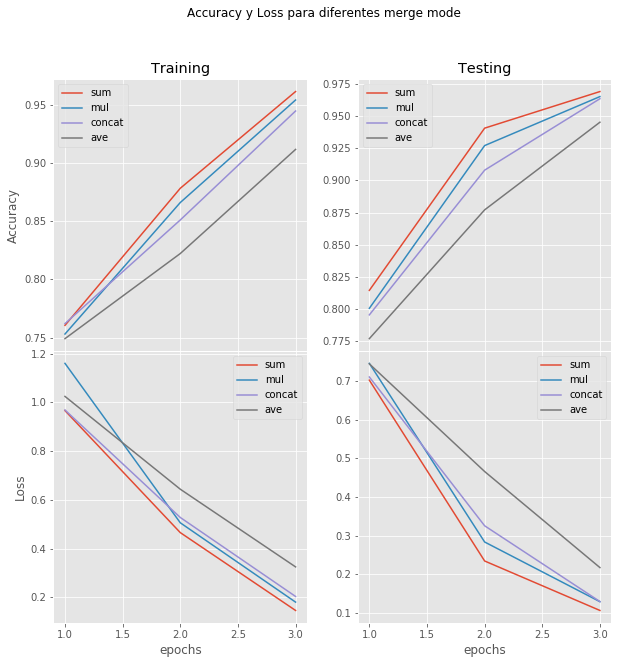

In [80]:
for i in range(len(modes)):
    print("Mode: {}\tLoss: {:.3f}\tAcc: {:.3f}\tTiempo: {:.1f}"
          .format(modes[i],scores[i][0],scores[i][1],times[i]))
    
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.subplots_adjust(hspace=0)
for i, mode in enumerate(modes):
    axes[0,0].plot(range(1,4), hists[i].history['acc'], label=mode)
    axes[0,1].plot(range(1,4), hists[i].history['val_acc'], label=mode)
    axes[1,0].plot(range(1,4), hists[i].history['loss'], label=mode)
    axes[1,1].plot(range(1,4), hists[i].history['val_loss'], label=mode)
axes[1,0].set_xlabel("epochs")
axes[1,1].set_xlabel("epochs")
axes[0,0].set_ylabel("Accuracy")
axes[1,0].set_ylabel("Loss")
axes[0,0].set_title("Training")
axes[0,1].set_title("Testing")
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.suptitle("Accuracy y Loss para diferentes merge mode")
plt.show()


> j) Utilice alguna de las red entrenadas, ojalá una con buen desempeño y muestre las predicciones, el *pos tager*, sobre algún ejemplo de pruebas, comente. Para entender qué son los símbolos *Part of speech tags* visite el siguiente link: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html 


In [81]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_len))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
score = model.evaluate(X_test, y_test, verbose=0)
print("Loss: {:.3f}\tAcc: {:.3f}".format(score[0],score[1]))  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 81, 100)           106400    
_________________________________________________________________
dense_7 (Dense)              (None, 81, 42)            4242      
Total params: 758,450
Trainable params: 758,450
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 81s 2ms/step - loss: 0.9674 - acc: 0.7589 - val_loss: 0.6952 - val_acc: 0.8047
Epoch 2/3
33656/33656 [==============================] - 90s 3ms/step - loss: 0.4404 - acc: 0.8845 - val_loss: 0.2203 - val_acc: 0.9426
Epoch 3/3
33656/33656 [==============================] - 79s 2ms/step - loss: 

In [83]:
i = 10
print("Se tomará el siguiente ejemplo: {}".format(X_test[i]))

Se tomará el siguiente ejemplo: [11543  1782 13884  4764  1479   827  3560 16690  1479  1732 19062  4764
 16690  7820 17383  1479  7807  2472 17011 14288  2056 11051 11076  2056
  5525 16690  8433 13154 14432 14288 11750 14126  1479 12432 13137  4780
 11890  1479 19432  8884 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980 14980
 14980 14980 14980 14980 14980 14980 14980 14980 14980]


In [89]:
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(list(lemmas)[w],list(labels)[pred]))

Lemma          : Pred
take           : VBZ
it             : PRP
up             : PRP$
,              : ,
the            : DT
man            : NN
return         : VBD
to             : TO
the            : DT
same           : JJ
place          : NN
,              : ,
to             : TO
find           : VB
that           : IN
the            : DT
wall           : NN
under          : IN
which          : WDT
he             : PRP
had            : VBD
been           : VBN
sit            : RB
had            : VBN
fallen         : VBN
to             : TO
piec           : VB
;              : NNS
and            : CC
he             : PRP
marvel         : NN
at             : IN
the            : DT
servic         : NN
render         : NN
him            : PRP
by             : IN
the            : DT
eagl           : NN
.              : .
ENDPAD         : ENDPAD
ENDPAD         : ENDPAD
ENDPAD         : ENDPAD
ENDPAD         : ENDPAD
ENDPAD         : ENDPAD
ENDPAD         : ENDPAD
ENDPAD         : ENDPAD

> k) Carge las palabras del dataset ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). Utilice el tamaño del *corpus* que le acomode a la memoria de su computador.

In [27]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 242693


> l) Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres, tal cual se realizó en c) con los *lemmas*, lo mismo para las etiquetas. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. Transforme las etiquetas a *one hot vector* como se realizó en c) y defina la red similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA) para *Deep Neural Network*. 

Se generan los nuevos conjuntos de datos.

In [28]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]

Confirmamos el largo mayor de los datos

In [29]:
max_len = 0
for lemma in dataX:
    max_len = max(len(lemma), max_len)
print("Tamaño sentencia más larga: ", max_len)

Tamaño sentencia más larga:  41


Se realiza el padding a los conjuntos de datos, pero esta vez se hará previamente a los datos, contrario a lo hecho en el punto c).

In [30]:
X = sequence.pad_sequences(dataX, maxlen=max_len, padding="pre", value=char_indices[null_character])
y = np.asarray([to_categorical(i, num_classes=len(chars)) for i in dataY])

Con esto las dimensiones de X e y son:

In [31]:
print("Dimensiones X: {}".format(X.shape))
print("Dimensiones y: {}".format(y.shape))

Dimensiones X: (242693, 41)
Dimensiones y: (242693, 72)


La matrix X tendrá vectores de la siguiente forma

In [32]:
X[1]

array([ 0, 33, 46, 36, 51,  1, 47, 38,  1, 36, 37, 45, 47, 46, 51, 52, 50,
       33, 52, 47, 50, 51,  1, 40, 33, 54, 37,  1, 45, 33, 50, 35, 40, 37,
       36,  1, 52, 40, 50, 47, 53], dtype=int32)

Y la matriz y será de la siguiente forma (one hot vector)

In [33]:
y[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

Se separa los datos en conjuntos de training y testing.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [35]:
X_train

array([[ 0, 37,  1, ..., 37,  1, 55],
       [ 0, 47,  1, ..., 55, 41, 44],
       [ 0,  1, 35, ..., 37, 52, 55],
       ...,
       [ 0, 35, 50, ..., 50,  1, 35],
       [ 0,  1, 48, ..., 40, 47, 51],
       [ 0,  1,  9, ..., 37,  1, 38]], dtype=int32)

In [64]:
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Train on 169885 samples, validate on 72808 samples
Epoch 1/10
169885/169885 [==============================] - 158s 933us/step - loss: 2.4227 - acc: 0.2976 - val_loss: 2.0808 - val_acc: 0.3898
Epoch 2/10
169885/169885 [==============================] - 161s 948us/step - loss: 1.9199 - acc: 0.4348 - val_loss: 1.7565 - val_acc: 0.4826
Epoch 3/10
169885/169885 [==============================] - 156s 921us/step - loss: 1.6655 - acc: 0.5097 - val_loss: 1.5949 - val_acc: 0.5326
Epoch 4/10
169885/169885 [==============================] - 156s 920us/step - loss: 1.5088 - acc: 0.5540 - val_loss: 1.5073 - val_acc: 0.5576
Epoch 5/10
169885/169885 [==============================] - 160s 941us/step - loss: 1.3926 - acc: 0.5856 - val_loss: 1.4652 - val_acc: 0.5730
Epoch 6/10
169885/169885 [==============================] - 162s 951us/step - loss: 1.2987 - acc: 0.6100 - val_loss: 1.4503 - val_acc: 0.5793
Epoch 7/10
169885/169885 [==============================] - 161s 947us/step - loss: 1.2132 - acc:

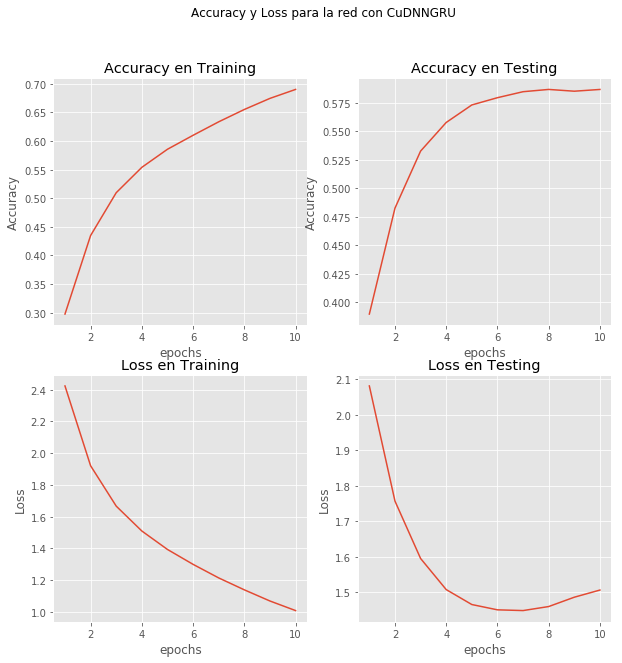

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axes[0,0].plot(range(1,11), hist.history['acc'])
axes[0,0].set_xlabel("epochs")
axes[0,0].set_ylabel("Accuracy")
axes[0,0].set_title("Accuracy en Training")
axes[0,1].plot(range(1,11), hist.history['val_acc'])
axes[0,1].set_xlabel("epochs")
axes[0,1].set_ylabel("Accuracy")
axes[0,1].set_title("Accuracy en Testing")
axes[1,0].plot(range(1,11), hist.history['loss'])
axes[1,0].set_xlabel("epochs")
axes[1,0].set_ylabel("Loss")
axes[1,0].set_title("Loss en Training")
axes[1,1].plot(range(1,11), hist.history['val_loss'])
axes[1,1].set_xlabel("epochs")
axes[1,1].set_ylabel("Loss")
axes[1,1].set_title("Loss en Testing")

plt.suptitle("Accuracy y Loss para la red con CuDNNGRU")
plt.show()

>  m) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente.

In [36]:
def predict_next_char(model, sentence, diversity=1.0):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds)
    return indices_char[next_index]

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

In [37]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X, y,validation_data=(X_test, y_test), batch_size=256, epochs=25, callbacks=[print_callback])

Train on 242693 samples, validate on 72808 samples
Epoch 1/25
242693/242693 [==============================] - 191s 786us/step - loss: 2.4262 - acc: 0.2972 - val_loss: 2.0535 - val_acc: 0.3893

----- Generating text after Epoch: 0
----- Generating with seed: "tes , politicians and religious leaders "
tes , politicians and religious leaders nas staicand singan s rohl en the is sfynce fee streire , of lisgorting ofongays . to1 a camrasad crswenterently in laiola wan an quasis alencrned a-blonestsorian . the dexreenter lesev indepened sath mangins . the has dity chasustay in an80 and bye-galaning thel weand lys ansinusedy comfings destersoush , u51 . foth ctsmuriats opelle metingeing chles prespenaly as the haul-th reperting miglallalsEpoch 2/25
242693/242693 [==============================] - 185s 763us/step - loss: 1.8994 - acc: 0.4389 - val_loss: 1.6734 - val_acc: 0.5081

----- Generating text after Epoch: 1
----- Generating with seed: "ilitants claimed responsibility for the "
ilitant


----- Generating text after Epoch: 23
----- Generating with seed: "letti has been under intense internation"
letti has been under intense international from the grand of the cashentic parleaming said it collipicagizer when held and other fireting prime minister ahia , legt-mendanch . wiched a vecate of iran , with the dead birded in a series of democracy , smail of nations sope 76 people refeesed ty outhik to protect the american desirence from the united states and indress during the scupe of beopned for new one of the has anded al-majhile inEpoch 25/25
242693/242693 [==============================] - 215s 887us/step - loss: 0.8367 - acc: 0.7359 - val_loss: 0.6315 - val_acc: 0.8073

----- Generating text after Epoch: 24
----- Generating with seed: "s primary court convicted mohaqiq of bla"
s primary court convicted mohaqiq of blamentil " in the pack . the united nations says president asker ia prinonees of the city 's militants briggles to gale among puriman officials are starkled , 

In [38]:
model.save("preguntam")

In [75]:
model.save_weights("model.h5")

In [39]:
hist.history

{'val_loss': [2.0535387582090476,
  1.6734164396284334,
  1.4699373522272163,
  1.3318832163469645,
  1.227094545493793,
  1.138191645492002,
  1.0637083427288574,
  0.9869275760839253,
  0.9302167746604452,
  0.8708591070388414,
  0.8223650492085112,
  0.7804190131900416,
  0.7465319716855728,
  0.7209102682799589,
  0.6952975623726307,
  0.6850331370194735,
  0.6611538935514508,
  0.6615735656703492,
  0.647158284669865,
  0.6407947064677302,
  0.6423053256090808,
  0.6339315050395684,
  0.6314552215321643,
  0.6263589327996307,
  0.631520692116218],
 'val_acc': [0.38927040985817046,
  0.5080760355939342,
  0.5645945500625436,
  0.6054005054455119,
  0.6336116909967675,
  0.6589797824021945,
  0.6808729809583537,
  0.7050049444788459,
  0.7216239974022226,
  0.7400835073330864,
  0.7550543896078658,
  0.7679513240237771,
  0.7778815514451134,
  0.7836776178048975,
  0.7929211075967936,
  0.7953246895814515,
  0.8014915943433919,
  0.8002417317105838,
  0.8046917920976586,
  0.8070267

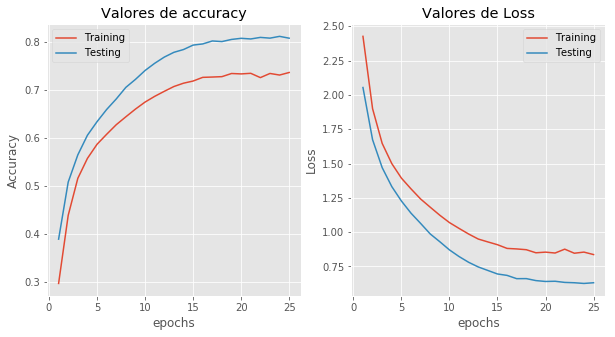

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].plot(range(1,26), hist.history['acc'])
axes[0].plot(range(1,26), hist.history['val_acc'])
axes[0].legend(["Training", "Testing"])
axes[0].set_xlabel("epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Valores de accuracy")
axes[1].plot(range(1,26), hist.history['loss'])
axes[1].plot(range(1,26), hist.history['val_loss'])
axes[1].legend(["Training", "Testing"])
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Valores de Loss")
plt.show()


> n) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.


In [41]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is a mannel . spands , includ , the no the hostil , and vote in an ara gangha raged have no wan generarall said with troops and those was masy on for parties . bothes , day in a sunni canol , which says in a bounch proving in a tunying reless that have said workin , has deficinal cash and secret inar and that . governalls militation , which , the pasest in mostly southwing by land and venezured seven

In [43]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is annating after . some gomdre . an and the seorens active on hands , the conditude , venezus in vere parsoin round has virus into says of inficr . batill , is not pilities and the to striked mith toot rises withorg says the visit go maktact , in a have said to huk , dayt har and in suppli in 2009 . but in 2003 and politions in south killed releas . the voting aldout in a surviveer and conting signe

In [42]:
sentence = "neural networks are "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "neural networks are "
neural networks are afghanint the assassing retorl 's parestinian meliad and entry former dowth of has dinator comes oppibials in the close outs depocraticn labmeally shripale " nor che-keal chipelen report in the gaza strip , teecsing inatilled lase toun month thut the military armed viclims have selitide . the repional action said the past . rominging cholden and whote propuses . " the news agency in the war in ber

In [48]:
sentence = "the war in gaza"
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "the war in gaza"
the war in gaza strip . the european and security . the u.s. embassy says it hasted it is complitions say they after stateh on the latest detainee two to string commission in and arrest president extovaries spokesman saturday in the 19th-, although the aderican spanes and a fighting explodian president jounnaliats and other in eucompars 's polish confilence in the northern contribution . the 67-year-old programs

In [49]:
sentence = ""
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: ""
 . . , , . , , , , . , . , . . . , . , . . , . , . . , , , . . . 's , . . . . . , , , , b . . . . , . , , . . . , , , . . , . . . . . . , , . . , . . . , , , , . . . , , . , . . . . , . , , , , , . . . , , , . , . h . , . . . , , . . . , . , . . . , . . . , . , , . , . . ) , . , . . , . , , , . . . . , , . , , , . , . . , , , , , . , , , , . . , . , , , . , , . . . . . , , , 's , , . . , . , , . .

## Referencias
- https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
- https://es.wikipedia.org/wiki/Etiquetado_gramatical